In [214]:
# library imports
import numpy as np
import random
import math
import matplotlib.pyplot as plt
import pandas as pd
import sys
from tqdm import trange, tqdm

# importing our helper functions
from helper import *

# Config
from config import * # we standardise config across all files
'''
NUM_CUSTOMERS = 50
NUM_CHARGERS = 30
NUM_VEHICLES = 10
BATTERY_CAPACITY = 10
ENERGY_PER_KM = 0.187
TIME_PER_KM = 3 # in minutes
TOTAL_TIME_ALLOWED = 600
'''

# hello()

'\nNUM_CUSTOMERS = 50\nNUM_CHARGERS = 30\nNUM_VEHICLES = 10\nBATTERY_CAPACITY = 10\nENERGY_PER_KM = 0.187\nTIME_PER_KM = 3 # in minutes\nTOTAL_TIME_ALLOWED = 600\n'

In [229]:
random.seed(5)

# Electric Vehicle Points
ev_pts = pd.read_csv("Unique_EV_Points.csv")
charge_pts = ev_pts.sample(n=NUM_CHARGERS)[['Longitude', 'Latitude']] # dataframe
charge_pts_list = list(charge_pts.itertuples(index=False, name=None)) # list

# Delivery locations Points
dl = pd.read_csv("DeliveryLocations.csv")
todays_locations = dl.sample(n=NUM_CUSTOMERS)
dl_list = list(todays_locations.itertuples(index=False, name=None))

# Fedex Ship Centre
fedex_centre = [(104.0023106, 1.3731437)]

locations = fedex_centre + dl_list + charge_pts_list # combined list of all locations
print(locations)

<class 'pandas.core.frame.DataFrame'>


## Calculate the distance, time and energy between locations

In [238]:
# Total nodes: 1 depot + customers + chargers
n = len(locations)
customer_nodes = list(range(1, 1 + NUM_CUSTOMERS)) # gets the index/nodes of customers
charger_nodes = list(range(1 + NUM_CUSTOMERS, n))  

# Compute Distance & Energy Matrices
distance_matrix = np.zeros((n, n))
time_matrix = np.zeros((n, n))
energy_matrix = np.zeros((n, n))

def calc_dist(p1, p2):
    """
    Calculates the straight-line (euclidean) distance
    """
    lon_diff = p1[0] - p2[0]
    lat_diff = p1[1] - p2[1]
    return 111 * np.sqrt(lon_diff**2 + lat_diff**2)

for i in range(n):
    for j in range(n):
        if i != j:
            dist = calc_dist(locations[i], locations[j])
            distance_matrix[i][j] = dist
            energy_matrix[i][j] = dist * ENERGY_PER_KM
            time_matrix[i][j] = dist * TIME_PER_KM

def total_distance(routes, locations):
    """
    Returns total distance of for all route in routes
    """
    dist = 0.0
    for route in routes:
        for i in range(len(route) - 1):
            dist += calc_dist(locations[route[i]], locations[route[i+1]])
    return dist

def num_activated_vehicles(routes):
    """
    Calculates number of activated vehicles
    """
    return len(routes) - sum(1 for route in routes if route == [0, 0])

In [139]:
random.seed(5)
# Helper Functions
def is_route_feasible(route, locations): # to be optimised
    """
    Ensures a single route is feasible by inserting charging stations if needed.
    Returns:
        - A new route with chargers inserted if feasible.
        - False if no feasible charger insertion exists.
    """
    battery = BATTERY_CAPACITY
    new_route = [route[0]]
    total_time_taken = 0

    for i in range(1, len(route)):
        prev, curr = new_route[-1], route[i]
        to_discharge = energy_matrix[prev][curr]
        
        # if desired destination uses too much battery
        if to_discharge > battery:
            # Find nearest charger that is reachable from prev and can reach curr
            inserted = False
            charger = np.argmin(distance_matrix[prev][1+NUM_CUSTOMERS:], axis=0) +1 + NUM_CUSTOMERS

            if curr < 1+NUM_CUSTOMERS: # next destination is not a charger
                d1 = energy_matrix[prev][charger]
                d2 = energy_matrix[charger][curr]

                if d1 <= battery and d2 <= BATTERY_CAPACITY:
                    new_route.append(charger)
                    new_route.append(curr)
                    total_time_taken += time_matrix[prev, charger] + time_matrix[charger, curr]
                    battery = BATTERY_CAPACITY-d2
                    inserted = True
                        
            else: # next destination is a charger
                # find a nearer charger
                d1 = energy_matrix[prev][charger]
                
                if d1 <= battery:
                    new_route.append(charger)
                    total_time_taken += time_matrix[prev, charger]
                    battery = BATTERY_CAPACITY
                    inserted = True
            
            if not inserted:
                return False  # infeasible
        else:
            battery -= to_discharge
            new_route.append(curr)

            # add time taken to travel
            total_time_taken += time_matrix[prev, curr]
        
            if curr >= 1 + NUM_CUSTOMERS:
                battery = BATTERY_CAPACITY
    
    # exceeded total time to complete
    if total_time_taken > TOTAL_TIME_ALLOWED:
        return False
        
    ### return new_route
    # Remove unnecessary chargers from route (to be optimised)
    optimized_route = [new_route[0]]
    battery = BATTERY_CAPACITY
    for i in range(1, len(new_route)):
        prev = optimized_route[-1]
        curr = new_route[i]
        to_discharge = energy_matrix[prev][curr]

        # If curr is a charger, check if we can skip it
        if curr >= 1 + NUM_CUSTOMERS and i + 1 < len(new_route):
            next_node = new_route[i + 1]
            to_next = energy_matrix[prev][next_node]
            if to_next <= battery:
                # Skip this charger
                continue

        battery -= to_discharge
        if curr >= 1 + NUM_CUSTOMERS:
            battery = BATTERY_CAPACITY
        optimized_route.append(curr)

    return optimized_route

def swap_routes(routes):
    """
    Swap client locations between two vehicles.
    """
    new_routes = [r[:] for r in routes]

    not_charger_or_depot = False

    # prevent swapping of chargers, only client locations
    while not_charger_or_depot == False:
        # choose 2 vehicles to swap routes
        veh_1, veh_2 = random.sample(range(len(new_routes)), 2)

        # randomly choose two client locations of the vehicles to swap
        i = random.randint(0, len(new_routes[veh_1])-1)
        j = random.randint(0, len(new_routes[veh_2])-1)

        if 0 < new_routes[veh_1][i] < 1 + NUM_CUSTOMERS and 0 < new_routes[veh_2][j] < 1 + NUM_CUSTOMERS and new_routes[veh_1][i] != new_routes[veh_2][j]:
            not_charger_or_depot = True
    
    new_routes[veh_1][i], new_routes[veh_2][j] = new_routes[veh_2][j], new_routes[veh_1][i]
    return new_routes

def swap_within_vehicle(routes):
    """
    Swap routes within one vehicle
    """
    new_routes = [r[:] for r in routes]

    customer_indices = []

    # Retry until we find a vehicle with at least 1 customer
    while len(customer_indices) < 2:
        vehicle = random.randint(0, len(new_routes) - 1)
        
        customer_indices = [i for i in range(len(new_routes[vehicle]))
                            if 0 < new_routes[vehicle][i] < 1 + NUM_CUSTOMERS]

    route = new_routes[vehicle]
    i, j = random.sample(customer_indices, 2)
    route[i], route[j] = route[j], route[i]
    new_routes[vehicle] = route

    return new_routes

def swap_k_opt(routes, k=2): # check again
    new_routes = [r[:] for r in routes] 

    veh = random.randint(0, len(new_routes) - 1)
    route = new_routes[veh]

    # Cannot perform k-opt on too short routes
    if len(route) <= k + 1:
        return new_routes

    # Only apply k-opt on the customer part of the route
    customer_indices = [i for i in range(1, len(route) - 1)  # exclude depot at start and end
                        if 0 < route[i] < 1 + NUM_CUSTOMERS]

    if len(customer_indices) < k:
        return new_routes

    # Choose two cut points i < j
    i, j = sorted(random.sample(customer_indices, 2))

    # Perform 2-opt swap: reverse the segment between i and j
    route[i:j+1] = reversed(route[i:j+1])

    new_routes[veh] = route
    return new_routes


In [175]:
random.seed(5)
def tweak_insert(routes):
    """
    Remove customer from one vehicle and insert to another vehicle
    """
    new_routes = [r[:] for r in routes] 
    veh_1, veh_2 = random.sample(range(len(new_routes)), 2)

    # Get all valid customer indices in veh_1 (not depot or charger)
    customer_indices = [i for i in range(len(new_routes[veh_1]))
                        if 0 < new_routes[veh_1][i] < 1 + NUM_CUSTOMERS]

    # Retry until we find a vehicle with at least 1 customer
    while not customer_indices:
        veh_1, veh_2 = random.sample(range(len(new_routes)), 2)
        customer_indices = [i for i in range(len(new_routes[veh_1]))
                            if 0 < new_routes[veh_1][i] < 1 + NUM_CUSTOMERS]

    # Select up to 3 customers
    num_to_move = min(1, len(customer_indices))
    from_indices = sorted(random.sample(customer_indices, num_to_move), reverse=True)

    customers = []
    for idx in from_indices:
        customers.append(new_routes[veh_1].pop(idx))

    # Ensure veh_2 route has depot structure
    if len(new_routes[veh_2]) < 2:
        new_routes[veh_2] = [0, 0]  # Insert depot if vehicle is inactive

    # Insert each customer at a random position in veh_2
    for customer in customers:
        insert_pos = random.randint(1, len(new_routes[veh_2]) - 1)
        new_routes[veh_2].insert(insert_pos, customer)

    return new_routes

new_routes = [[0, 5, 3, 8,15,14,17, 0], [0, 2, 1, 6,12 , 11, 13, 0]]
tweak_insert(new_routes)

[[0, 5, 3, 8, 15, 14, 17, 13, 0], [0, 2, 1, 6, 12, 11, 0]]

## Generate a Basic Feasible Solution and View it

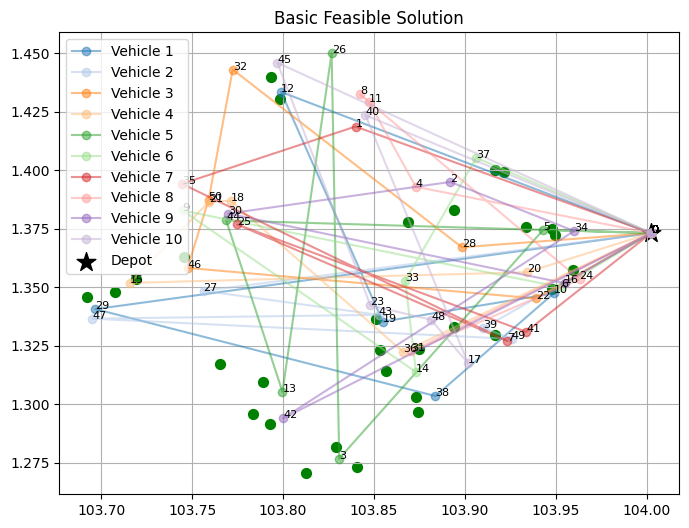

In [211]:
random.seed(5)

def generate_initial_solution():# -> list:
    """
    naive method - create BFS by randomly assigning customers to vehicles
    """
    nodes = list(range(1, 1 + NUM_CUSTOMERS))  # customer indices
    random.shuffle(nodes)
    split = np.array_split(nodes, NUM_VEHICLES)

    routes = []
    for chunk in split:
        # starting and ending is at the depot
        r = [0] + list(chunk) + [0]
        # randomly insert a charger if route is long
        if not is_route_feasible(r, locations):
            r.insert(len(r)//2, random.randint(1 + NUM_CUSTOMERS, len(locations) - 1))
        routes.append(r)
    
    return routes

colors = [plt.get_cmap("tab20")(i) for i in range(NUM_VEHICLES)]
current_solution = generate_initial_solution()
locations_e = np.array([[lat, lon] for (lat, lon) in locations])

plt.figure(figsize=(8, 6))
for i, route in enumerate(current_solution):
    
    pts = locations_e[route]
    plt.plot(pts[:, 0], pts[:, 1], color=colors[i], alpha=0.5, marker='o', label=f"Vehicle {i+1}")

    for idx in route:
        plt.text(locations_e[idx, 0], locations_e[idx, 1], str(idx), fontsize=8)

plt.scatter(*locations_e[0], c='black', s=200, marker='*', label='Depot')
for k in range(1+NUM_CUSTOMERS, n):
    plt.scatter(*locations_e[k], c='green', s=50, marker='o')

plt.title("Basic Feasible Solution")
plt.legend()
plt.grid(True)
plt.show()

## Simulated Annealing Algorithm

In [181]:
random.seed(5)
best_cost = better_cost = total_distance(current_solution, locations)
best_solution = better_solution = current_solution

INIT_TEMP = 10000
COOL_RATE = 0.95
curr_temp = INIT_TEMP
MAX_ITER = 100000

iterations = []
costs = []

true_it = 0

for it in trange(MAX_ITER):
    feasible = False
    all_route_feasible = True

    while not feasible:
        # if random.random() < 0.5 and num_activated_vehicles(better_solution) >= 3:
        if random.random() < 0.5:
            candidate = tweak_insert(better_solution)
        else:
            candidate = swap_within_vehicle(better_solution)

        candidate_routes = []
        all_route_feasible = True
        for r in candidate:
            route = is_route_feasible(r, locations)
            if route is False:
                all_route_feasible = False
            else:
                candidate_routes.append(route)
        
        if all_route_feasible:
            feasible = True

    current_cost = total_distance(candidate_routes, locations)
    delta = current_cost - better_cost
    
    if delta < 0 or random.random() < math.exp(-delta / curr_temp):
        better_solution, better_cost = candidate_routes, current_cost
        iterations.append(it)
        costs.append(better_cost)

        # store the best solution separately jic after MAX_ITERs, the solution is not the best
        if delta < 0:
            best_solution, best_cost = candidate_routes, current_cost
    
    true_it += 1
    if true_it > 100: 
        curr_temp = INIT_TEMP / (1+(1-COOL_RATE) * it)
        true_it = 0
            
    if curr_temp < 1e-3:
        break


print(f"\nBest total distance: {best_cost:.2f} km")

100%|██████████| 100000/100000 [01:23<00:00, 1194.49it/s]
Best total distance: 195.79 km



0 🪫100%, 0 🪫100%, 
 Vehicle 1: Time Taken: 0.0. Energy_Taken: 0.0. 
Route is feasible [0, 0]
0 🪫100%, 5 🪫88%, 20 🪫84%, 37 🪫72%, 4 🪫64%, 25 🪫44%, 18 🪫42%, 30 🪫40%, 44 🪫40%, 21 🪫37%, 27 🪫29%, 46 🪫27%, 15 🪫20%, 29 🪫15%, 47 🪫14%, 🔋74, 35 🪫85%, 9 🪫83%, 50 🪫80%, 1 🪫62%, 11 🪫59%, 8 🪫58%, 12 🪫49%, 32 🪫43%, 45 🪫38%, 26 🪫32%, 40 🪫25%, 23 🪫8%, 🔋55, 39 🪫88%, 33 🪫78%, 19 🪫73%, 36 🪫70%, 31 🪫69%, 38 🪫64%, 14 🪫61%, 17 🪫55%, 7 🪫50%, 49 🪫50%, 41 🪫48%, 16 🪫42%, 0 🪫31%, 
 Vehicle 2: Time Taken: 401.16591365853895. Energy_Taken: 25.0. 
Route is feasible [0, 5, 20, 37, 4, 25, 18, 30, 44, 21, 27, 46, 15, 29, 47, 74, 35, 9, 50, 1, 11, 8, 12, 32, 45, 26, 40, 23, 55, 39, 33, 19, 36, 31, 38, 14, 17, 7, 49, 41, 16, 0]
0 🪫100%, 24 🪫91%, 6 🪫89%, 34 🪫83%, 2 🪫69%, 28 🪫63%, 3 🪫39%, 42 🪫32%, 13 🪫30%, 43 🪫17%, 48 🪫11%, 🔋71, 22 🪫90%, 10 🪫88%, 0 🪫76%, 
 Vehicle 3: Time Taken: 186.19378291343554. Energy_Taken: 11.6. 
Route is feasible [0, 24, 6, 34, 2, 28, 3, 42, 13, 43, 48, 71, 22, 10, 0]
0 🪫100%, 0 🪫100%, 
 Vehicle 4: Ti

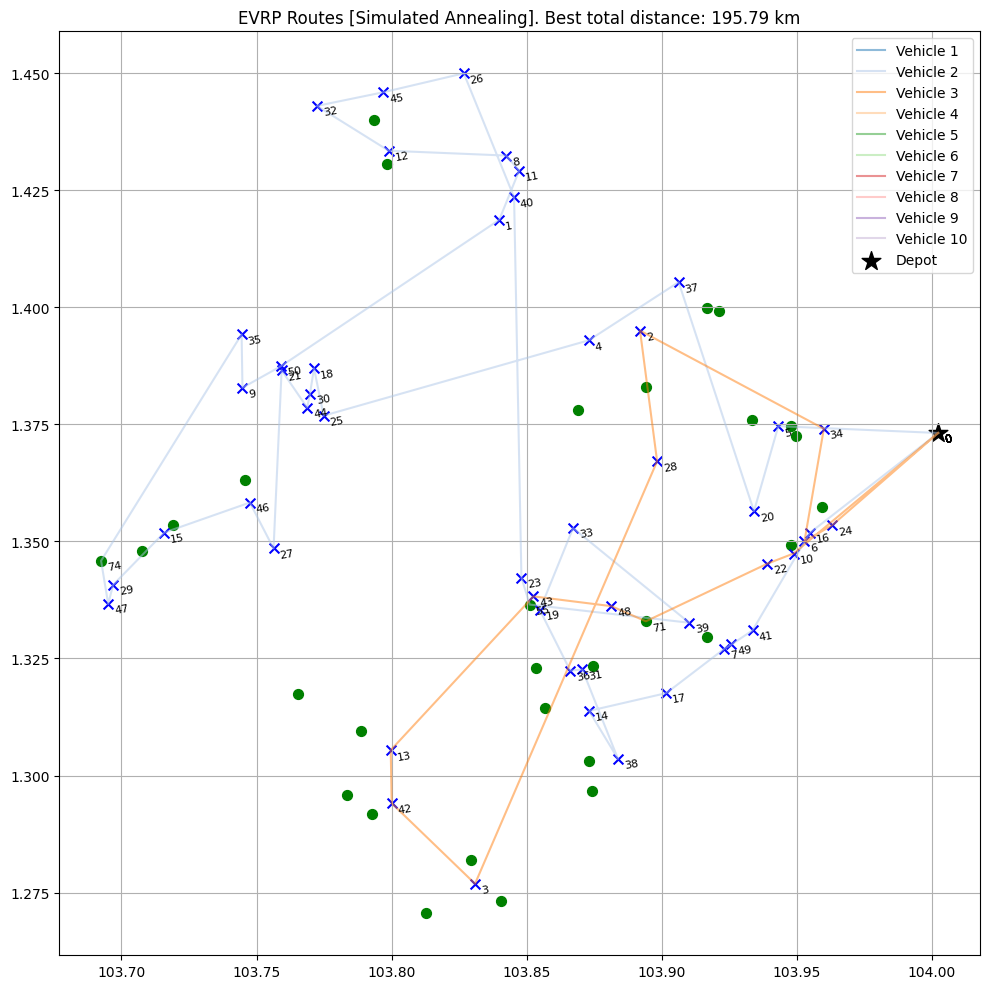

In [205]:
# Plot Optimal Routes
for v, route in enumerate(best_solution):
    time_taken = 0  
    energy_taken = 0
    battery_level = BATTERY_CAPACITY
    prev_pt = 0
    for point in route:
        time_taken += time_matrix[prev_pt][point]
        energy_taken += energy_matrix[prev_pt][point]
        battery_level -= energy_matrix[prev_pt][point]
        prev_pt = point
        
        if point < 1+NUM_CUSTOMERS:
            print(f"{round(point)} 🪫{round(battery_level/BATTERY_CAPACITY * 100)}%", end=", ")
        else:
            battery_level = BATTERY_CAPACITY
            print(f"🔋{round(point)}", end=", ")

    print(f"\n Vehicle {v+1}: Time Taken: {time_taken}. Energy_Taken: {energy_taken:.1f}. ")
    print(f"Route is feasible {is_route_feasible(route, locations)}")


# conversion_to_allow_indexing
locations_e = np.array([[lon, lat] for (lon, lat) in locations])

plt.figure(figsize=(10, 10))
for i, route in enumerate(best_solution):
    pts = locations_e[route]
    plt.plot(pts[:, 0], pts[:, 1], color=colors[i], alpha=0.5, label=f"Vehicle {i+1}")

    for idx in route:
        # offset slightly
        plt.text(locations_e[idx, 0] + 0.002, locations_e[idx, 1] - 0.002, str(idx), fontsize=8, rotation=10.)
        
plt.scatter(*locations_e[0], c='black', s=200, marker='*', label='Depot')
for k in range(1+NUM_CUSTOMERS, n):
    plt.scatter(*locations_e[k], c='green', s=50, marker='o')
for k in range(1, NUM_CUSTOMERS+1):
    plt.scatter(*locations_e[k], c='blue', s=50, marker='x')

plt.title(f"EVRP Routes [Simulated Annealing]. Best total distance: {best_cost:.2f} km")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Costs vs Iterations')

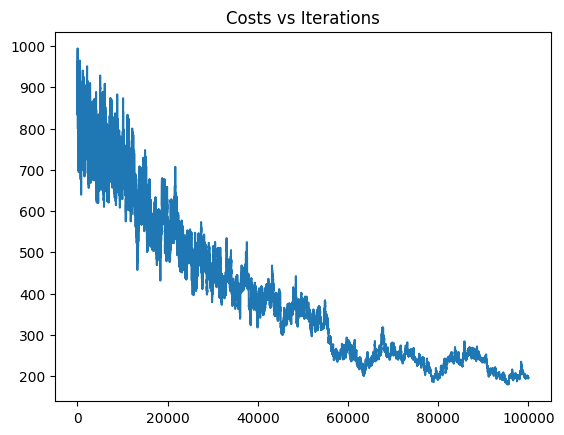

In [187]:
plt.plot(iterations, costs)
plt.title("Costs vs Iterations")
